##Đồ án môn DS102 Học Máy Thống Kê
#**NHẬN DIỆN CẢM XÚC CON NGƯỜI THÔNG QUA DỌNG NÓI - SPEECH EMOTION RECOGNITION**

*Thành viên 1:* Châu Tấn - 20520926

*Thành viên 2:* Ngô Đức Vũ - 20520950

*Thành viên 3:* Nguyễn Trần Anh Đức - 20521198



#1. Tải và khai báo các thư viện cần thiết

In [ ]:
import pandas as pd
import numpy as np
!pip install np_utils
import os
import sys
import pickle
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf 
# to play the audio files
from IPython.display import Audio
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 512 kB/s 
  Created wheel for np-utils: filename=np_utils-0.6.0-py3-none-any.whl size=56459 sha256=b09ab2c0476e0b8cde2eac2361eb3c0ab49edaf07f14770c5aca9f02300f6486
  Stored in directory: /root/.cache/pip/wheels/d2/83/71/a781667865955ae7dc18e5a4038401deb56d96eb85d3a5f1c0
Successfully built np-utils


# 2. Tải về và tiền xử lý bộ dữ liệu
## 2.1. Tải về bộ dữ liệu
Nguồn dữ liệu: https://www.kaggle.com/datasets/dmitrybabko/speech-emotion-recognition-en

Bộ dữ liệu này là sự kết hợp của 4 bộ dữ liệu CREMA, RAVDESS, SAVEE và TESS. Độ lớn của 4 bộ dữ liệu này gộp lại là 1.64 GB.

Để cho việc thao tác trên colab được suôn sẻ hơn, thì em đã tải bộ dữ liệu về máy tính cá nhân rồi upload bộ dữ liệu này lên drive. Sau đó em chỉnh sửa lại phân quyền của file dữ liệu rồi trích xuất id của file dữ liệu để tải qua máy chủ colab tiện lợi hơn.

In [ ]:
!gdown --id 1CWtqTHCcwa37R8bXyZgF4YYB7q4NZxl9 --output dataset
!mkdir dataset
!cd dataset
!unzip '/content/dataset'

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: Crema/1088_IWW_FEA_XX.wav  
  inflating: Crema/1088_IWW_HAP_XX.wav  
  inflating: Crema/1088_IWW_NEU_XX.wav  
  inflating: Crema/1088_IWW_SAD_XX.wav  
  inflating: Crema/1088_MTI_ANG_XX.wav  
  inflating: Crema/1088_MTI_DIS_XX.wav  
  inflating: Crema/1088_MTI_FEA_XX.wav  
  inflating: Crema/1088_MTI_HAP_XX.wav  
  inflating: Crema/1088_MTI_NEU_XX.wav  
  inflating: Crema/1088_MTI_SAD_XX.wav  
  inflating: Crema/1088_TAI_ANG_XX.wav  
  inflating: Crema/1088_TAI_DIS_XX.wav  
  inflating: Crema/1088_TAI_FEA_XX.wav  
  inflating: Crema/1088_TAI_HAP_XX.wav  
  inflating: Crema/1088_TAI_NEU_XX.wav  
  inflating: Crema/1088_TAI_SAD_XX.wav  
  inflating: Crema/1088_TIE_ANG_XX.wav  
  inflating: Crema/1088_TIE_DIS_XX.wav  
  inflating: Crema/1088_TIE_FEA_XX.wav  
  inflating: Crema/1088_TIE_HAP_XX.wav  
  inflating: Crema/1088_TIE_NEU_XX.wav  
  inflating: Crema/1088_TIE_SAD_XX.wav  
  inflating: Crema/1088_TSI_ANG_XX.wav  


##2.2. Tiền xử lý dữ liệu
Bộ dữ liệu được tải về là tập hợp của bốn bộ dữ liệu khác nhau. Do đó chúng không có sự đồng nhất về format hay nhãn. Tuy nhiên điểm chung của chúng là đều có nhãn trên tên của các file. Do đó, việc gán nhãn của bộ dữ liệu này hoàn toàn có thể được làm bằng một cách tự động dễ dàng mà không tốn quá nhiều sức lực hay thời gian.

In [ ]:
# Tạo đường dẫn của 4 bộ dữ liệu vừa được giải nén
Ravdess = "/content/Ravdess/"
Crema = "/content/Crema/"
Tess = "/content/Tess/"
Savee = "/content/Savee/"

###2.2.1. Xử lý bộ dữ liệu RAVDESS
Cụ thể về bộ dữ liệu thì mọi người có thể đọc trong file codebook của bộ dữ liệu RAVDESS

Nội dung chủ yếu của phần này thì chúng mình sẽ chú trọng vào việc tách label ra khỏi tên của file đó.

Đọc kỹ codebook thì chúng ta sẽ thấy rằng, phần label của bộ dữ liệu sẽ là phần số thứ 3 từ trái sang phải.

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actors = os.listdir(Ravdess + dir)
    for actor in actors:
      file_list = os.listdir(Ravdess + dir + '/' + actor)
      for file in file_list:
          part = file.split('.')[0]
          part = part.split('-')
          # third part in each file represents the emotion associated to that file.
          file_emotion.append(int(part[2]))
          file_path.append(Ravdess + dir + '/' + actor + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df

Emotions                                               Path
0     surprise  /content/Ravdess/audio_speech_actors_01-24/Act...
1      disgust  /content/Ravdess/audio_speech_actors_01-24/Act...
2     surprise  /content/Ravdess/audio_speech_actors_01-24/Act...
3         calm  /content/Ravdess/audio_speech_actors_01-24/Act...
4     surprise  /content/Ravdess/audio_speech_actors_01-24/Act...
...        ...                                                ...
1435   disgust  /content/Ravdess/audio_speech_actors_01-24/Act...
1436      calm  /content/Ravdess/audio_speech_actors_01-24/Act...
1437   disgust  /content/Ravdess/audio_speech_actors_01-24/Act...
1438     angry  /content/Ravdess/audio_speech_actors_01-24/Act...
1439   disgust  /content/Ravdess/audio_speech_actors_01-24/Act...

[1440 rows x 2 columns]

###2.2.2. Xử lý bộ dữ liệu CREMA
Cụ thể về bộ dữ liệu thì mọi người có thể đọc trong file codebook của bộ dữ liệu CREMA

Đọc kỹ codebook thì chúng ta sẽ thấy rằng, phần label của bộ dữ liệu sẽ là thành phần thứ 3 từ trái sang phải. Ví dụ như HAP là happy, ANG là angry,...

In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df

Emotions                                Path
0     disgust  /content/Crema/1021_DFA_DIS_XX.wav
1        fear  /content/Crema/1058_IEO_FEA_LO.wav
2     neutral  /content/Crema/1066_ITS_NEU_XX.wav
3       angry  /content/Crema/1055_IOM_ANG_XX.wav
4       angry  /content/Crema/1075_TAI_ANG_XX.wav
...       ...                                 ...
7437      sad  /content/Crema/1047_IWW_SAD_XX.wav
7438    angry  /content/Crema/1026_TSI_ANG_XX.wav
7439    angry  /content/Crema/1033_IWL_ANG_XX.wav
7440  neutral  /content/Crema/1012_IEO_NEU_XX.wav
7441     fear  /content/Crema/1054_IWW_FEA_XX.wav

[7442 rows x 2 columns]

###2.2.3. Xử lý bộ dữ liệu TESS

Cụ thể về bộ dữ liệu thì mọi người có thể đọc trong file codebook của bộ dữ liệu TESS

Đọc kỹ codebook thì chúng ta sẽ thấy rằng, phần label của bộ dữ liệu sẽ là phần số thứ đầu tiên từ phải sang trái (Không tính đuôi .wav) .

In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df

Emotions                                             Path
0        fear        /content/Tess/OAF_Fear/OAF_wheat_fear.wav
1        fear         /content/Tess/OAF_Fear/OAF_vote_fear.wav
2        fear         /content/Tess/OAF_Fear/OAF_thin_fear.wav
3        fear         /content/Tess/OAF_Fear/OAF_name_fear.wav
4        fear         /content/Tess/OAF_Fear/OAF_deep_fear.wav
...       ...                                              ...
2795  neutral    /content/Tess/OAF_neutral/OAF_rat_neutral.wav
2796  neutral   /content/Tess/OAF_neutral/OAF_deep_neutral.wav
2797  neutral    /content/Tess/OAF_neutral/OAF_dab_neutral.wav
2798  neutral  /content/Tess/OAF_neutral/OAF_learn_neutral.wav
2799  neutral  /content/Tess/OAF_neutral/OAF_lease_neutral.wav

[2800 rows x 2 columns]

###2.2.4. Bộ dữ liệu SAVEE

Cụ thể về bộ dữ liệu thì mọi người có thể đọc trong file codebook của bộ dữ liệu SAVEE

Đọc kỹ codebook thì chúng ta sẽ thấy rằng, phần label của bộ dữ liệu sẽ là ký tự đầu tiên (hoặc 2 ký tự đầu tiên đối với nhãn sad) phần số thứ 2 từ trái sang phải.

In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df

Emotions                        Path
0        fear   /content/Savee/KL_f09.wav
1     disgust   /content/Savee/JE_d03.wav
2     disgust   /content/Savee/KL_d12.wav
3     neutral   /content/Savee/JK_n22.wav
4     disgust   /content/Savee/KL_d03.wav
..        ...                         ...
475  surprise  /content/Savee/KL_su06.wav
476      fear   /content/Savee/KL_f06.wav
477   neutral   /content/Savee/KL_n25.wav
478       sad  /content/Savee/KL_sa12.wav
479     happy   /content/Savee/KL_h15.wav

[480 rows x 2 columns]

###2.2.5. Tổng hợp lại bộ dữ liệu trên
Sau khi chúng ta đã xử lý xong 4 bộ dữ liệu trên thì chúng ta có thể ghép chúng lại với nhau thành một bộ dữ liệu hoàn chỉnh

In [ ]:
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path

Emotions                                               Path
0    surprise  /content/Ravdess/audio_speech_actors_01-24/Act...
1     disgust  /content/Ravdess/audio_speech_actors_01-24/Act...
2    surprise  /content/Ravdess/audio_speech_actors_01-24/Act...
3        calm  /content/Ravdess/audio_speech_actors_01-24/Act...
4    surprise  /content/Ravdess/audio_speech_actors_01-24/Act...
..        ...                                                ...
475  surprise                         /content/Savee/KL_su06.wav
476      fear                          /content/Savee/KL_f06.wav
477   neutral                          /content/Savee/KL_n25.wav
478       sad                         /content/Savee/KL_sa12.wav
479     happy                          /content/Savee/KL_h15.wav

[12162 rows x 2 columns]

#3. Khám phá dữ liệu
##3.1. Đếm số lượng nhãn của từng nhãn dữ liệu

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


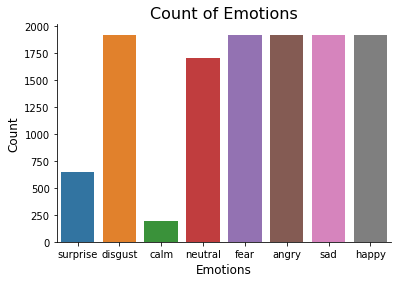

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

##3.2. Khám phá bên trong của từng file âm thanh theo nhãn. 

In [ ]:
# Viết hàm để trực quan hóa các dạng của file âm thanh, theo mình tìm hiểu thì có nhiều cách để trực quan một file âm thanh đó là sử dụng waveplot và spectrogram
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

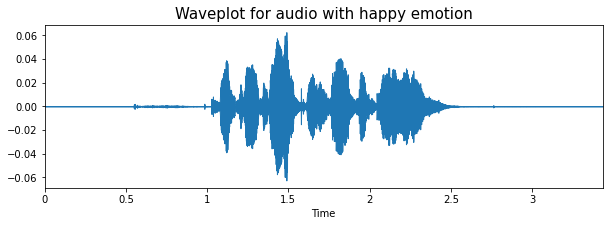

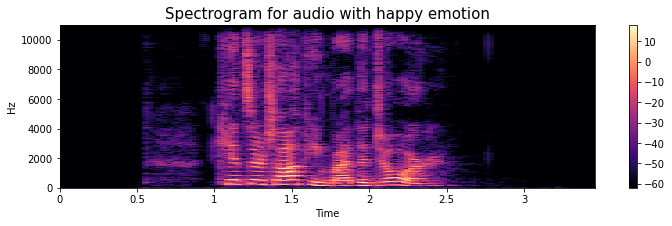

In [ ]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

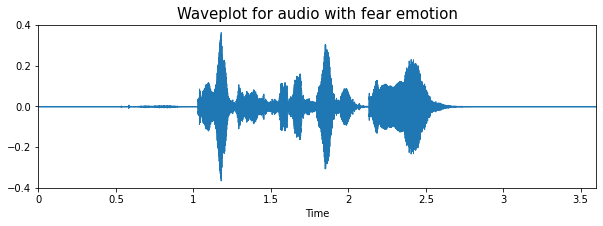

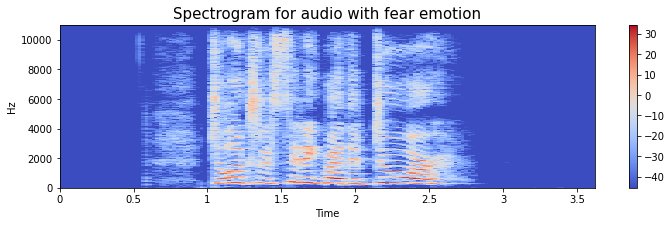

In [ ]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

/content/Ravdess/audio_speech_actors_01-24/Actor_22/03-01-05-02-01-01-22.wav


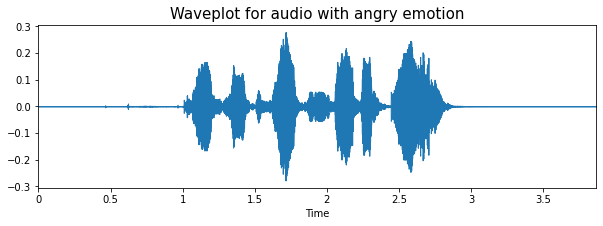

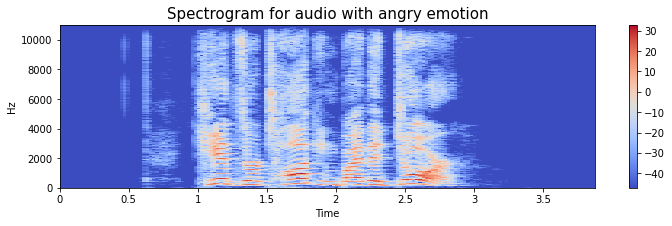

In [ ]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
print(path)
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

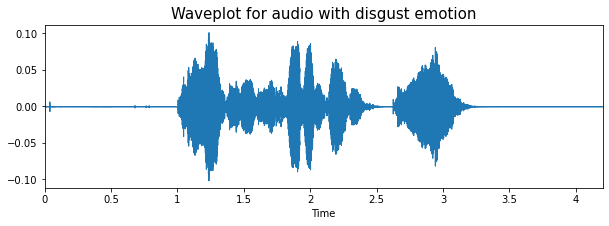

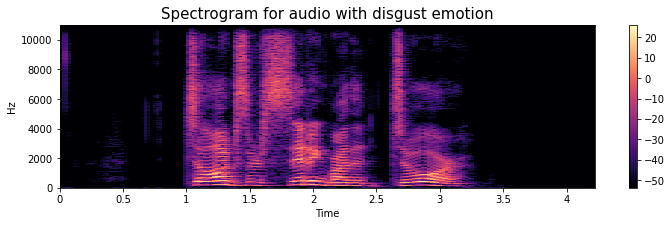

In [ ]:
emotion='disgust'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

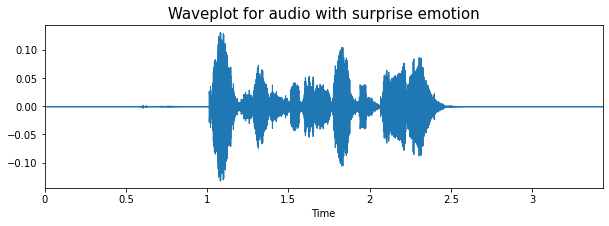

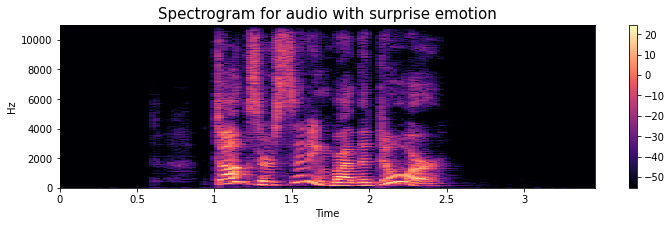

In [ ]:
emotion='surprise'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

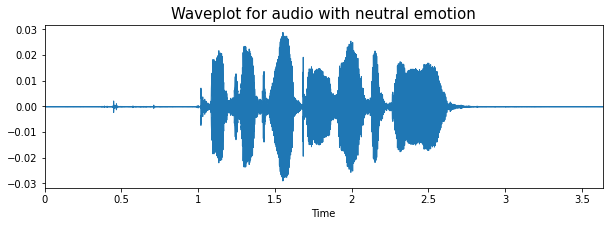

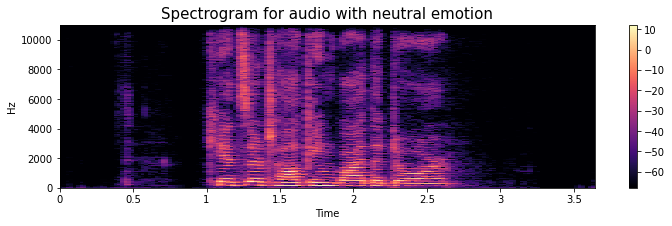

In [ ]:
emotion='neutral'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

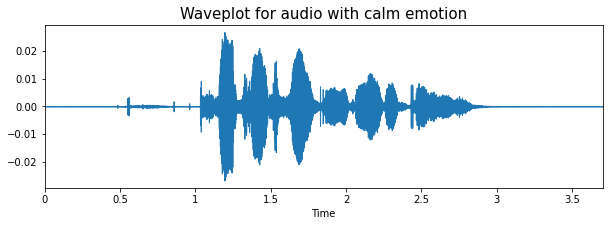

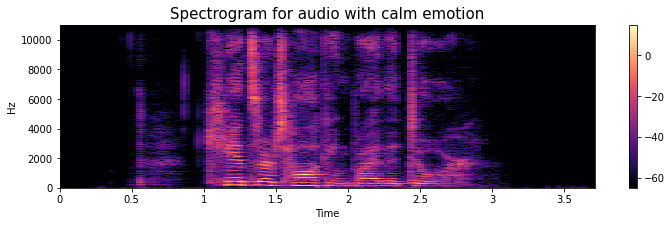

In [ ]:
emotion='calm'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

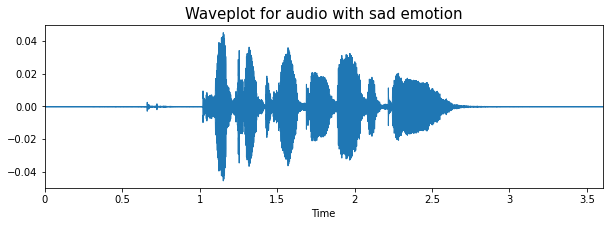

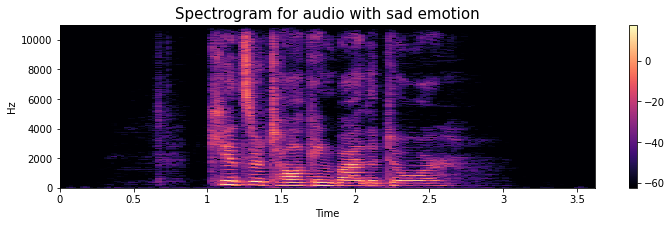

In [ ]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

#3. Trích xuất đặc trưng
Trích xuất đặc trưng rất quan trọng trong việc chọn ra những đặc trưng phù hợp nhất để đưa vào mô hình nhằm đưa ra kết quả cao nhất.

Giống như các bài toán khác về CV hoặc NLP thì mô hình cũng không thể hiểu được 1 file âm thanh được. Do đó chúng ta phải có cách để số hóa file âm thanh và đưa nó vào mô hình để mô hình có thể hiểu được, học được và đưa ra kết luận.

File âm thanh sẽ có dạng là những sóng âm. Ta có thể số hóa âm thanh dưới dạng một không gian 3 chiều: tần số, biên độ và thời gian

In [ ]:
# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
len(X), len(Y), data_path.Path.shape

(36486, 36486, (12162,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.197125  0.532450  0.569088  0.585639  0.624296  0.622050  0.590787   
1  0.227024  0.571788  0.607547  0.619187  0.685630  0.687537  0.614959   
2  0.150271  0.564916  0.493822  0.543641  0.586964  0.607552  0.577171   
3  0.162091  0.575182  0.574861  0.572571  0.609911  0.706694  0.650175   
4  0.207253  0.632646  0.615552  0.601238  0.601374  0.665840  0.745446   

          7         8         9  ...       153       154       155       156  \
0  0.617544  0.713987  0.729333  ...  0.000134  0.000094  0.000094  0.000085   
1  0.645204  0.724927  0.721266  ...  0.000136  0.000096  0.000096  0.000087   
2  0.563684  0.621082  0.721047  ...  0.000026  0.000029  0.000018  0.000016   
3  0.568595  0.592709  0.558874  ...  0.000063  0.000121  0.000109  0.000038   
4  0.632385  0.597378  0.605688  ...  0.000072  0.000130  0.000119  0.000048   

        157       158       159       160           161    labels  
0  0.000116  0.000140  0.000117  0.000052  5.476944e-06  surprise  
1  0.000119  0.000142  0.000120  0.000054  7.908225e-06  surprise  
2  0.000016  0.000022  0.000017  0.000007  3.790214e-07  surprise  
3  0.000067  0.000055  0.000035  0.000010  2.749870e-06   disgust  
4  0.000076  0.000063  0.000044  0.000020  1.242856e-05   disgust  

[5 rows x 163 columns]

#4. Xây dựng các mô hình phân loại
##4.1. Chuẩn bị dữ liệu

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
Y1 = Features['labels'].values
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [ ]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

##4.2. Mô hình Convulational Neural Network (CNN)
###4.2.1. Xây dựng mô hình và quá trình training của mô hình

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
def CNN_model():
  model=Sequential()
  model.add(Conv1D(256, kernel_size=8, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  model.add(Conv1D(128, kernel_size=8, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  model.add(Conv1D(64, kernel_size=8, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
  

  model.add(Conv1D(32, kernel_size=8, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  model.add(Flatten())
  model.add(Dense(units=16, activation='relu'))
  

  model.add(Dense(units=8, activation='softmax'))
  model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy', f1_m])

  model.summary()
  return model

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
model = CNN_model()
history=model.fit(x_train, y_train, batch_size=128, epochs=30, validation_data=(x_test, y_test), callbacks=[rlrp])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 162, 256)          2304      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 81, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 81, 128)           262272    
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 41, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 41, 64)            65600     
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 21, 64)          

###4.2.2. Đánh giá mô hình

In [ ]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0          disgust       disgust
1            angry         angry
2             fear          fear
3              sad       disgust
4             fear       neutral
5          disgust          fear
6             calm          calm
7            happy         happy
8            angry         angry
9          disgust       disgust

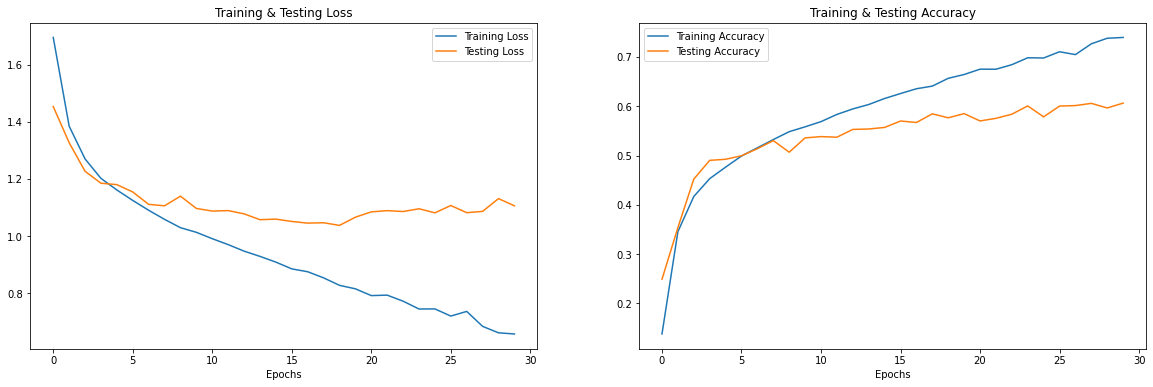

In [ ]:
from sklearn.metrics import f1_score
epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['f1_m']
train_loss = history.history['loss']
test_acc = history.history['val_f1_m']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

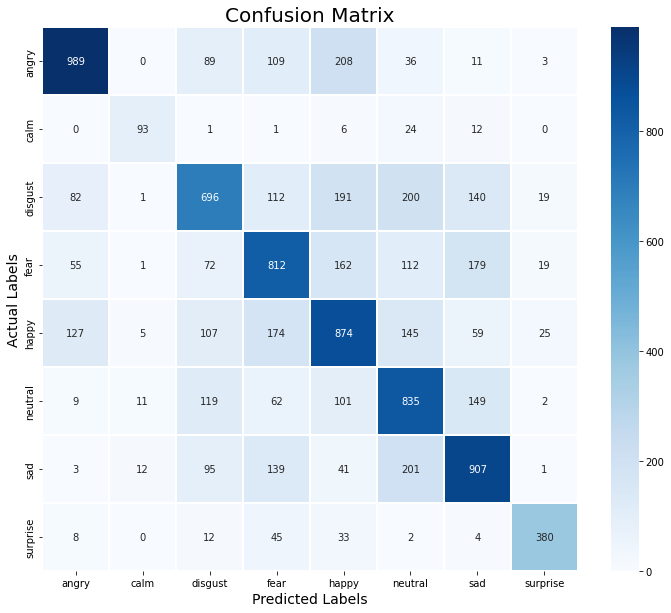

0.6123657092742819


In [ ]:
# y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(f1_score(y_test, y_pred, average="micro"))

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.79      0.73      0.76      1445
        calm       0.67      0.77      0.72       137
     disgust       0.50      0.64      0.56      1441
        fear       0.63      0.55      0.59      1412
       happy       0.61      0.61      0.61      1516
     neutral       0.78      0.41      0.53      1288
         sad       0.55      0.76      0.64      1399
    surprise       0.87      0.80      0.84       484

    accuracy                           0.63      9122
   macro avg       0.68      0.66      0.66      9122
weighted avg       0.65      0.63      0.63      9122



##4.4. Mô hình Logistic Regression

In [ ]:
x_train.shape
Y1.shape
encoder1=OrdinalEncoder()
Y1 = encoder1.fit_transform(np.array(Y1).reshape(-1, 1))
x_train1, x_test1, y_train1, y_test1 = train_test_split(X, Y1, test_size=0.2, random_state=42)
scaler = StandardScaler()
x_train1 = scaler.fit_transform(x_train1)
x_test1 = scaler.transform(x_test1)
print(y_train1.shape, x_train1.shape)

(29188, 1) (29188, 162)


In [ ]:
from pandas.core.internals.construction import to_arrays
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression(multi_class='ovr', solver='saga', max_iter=100000, penalty="l1")
encoder1 = OrdinalEncoder()
print(y_train1.shape)
# x_train1 = x_train
y_pred1 =model1.fit(x_train1, y_train1.ravel())
print(y_train1)
y_pred1 = model1.predict(x_test1)

(29188, 1)
[[5.]
 [3.]
 [2.]
 ...
 [2.]
 [3.]
 [3.]]


In [ ]:
print(y_pred1.shape)
print(y_test1.shape)

(7298,)
(7298, 1)


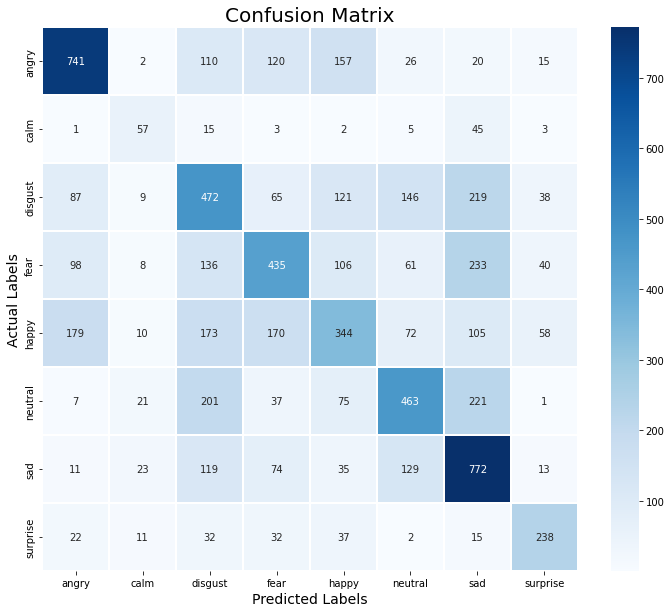

In [ ]:
cm = confusion_matrix(y_test1, y_pred1)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test1, y_pred1))

              precision    recall  f1-score   support

         0.0       0.65      0.62      0.63      1191
         1.0       0.40      0.44      0.42       131
         2.0       0.38      0.41      0.39      1157
         3.0       0.46      0.39      0.42      1117
         4.0       0.39      0.31      0.35      1111
         5.0       0.51      0.45      0.48      1026
         6.0       0.47      0.66      0.55      1176
         7.0       0.59      0.61      0.60       389

    accuracy                           0.48      7298
   macro avg       0.48      0.49      0.48      7298
weighted avg       0.48      0.48      0.48      7298



##4.5. Mô hình SVM

In [ ]:
from sklearn.svm import SVC
model2 = SVC(decision_function_shape="ovr", gamma="auto")
encoder2 = OrdinalEncoder()
x_train2, y_train2, x_test2, y_test2 = x_train1, y_train1, x_test1, y_test1
print(y_train2.shape)
training_2=model2.fit(x_train2, y_train2)
print(y_train2)
y_pred2 = model2.predict(x_test1)

(29188, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[5.]
 [3.]
 [2.]
 ...
 [2.]
 [3.]
 [3.]]


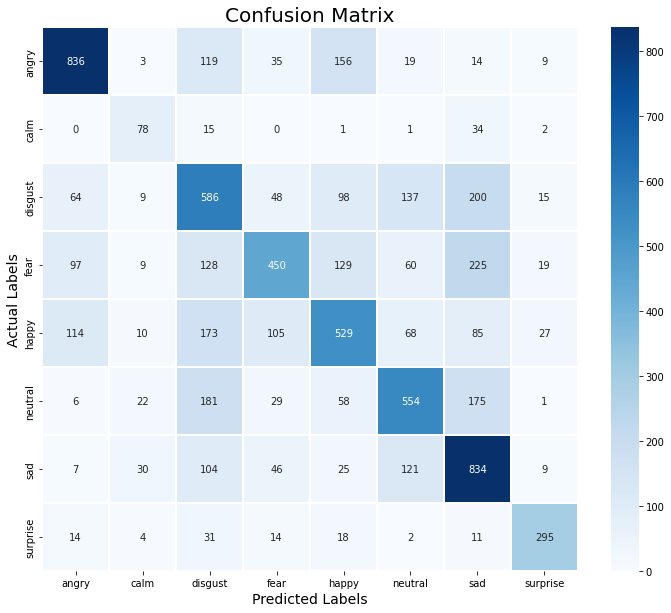

0.5702932310221979


In [ ]:
from sklearn.metrics import f1_score
cm = confusion_matrix(y_test2, y_pred2)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(f1_score(y_test2, y_pred2, average="micro"))

##4.6. Mô hình K Nearest Neighbour (Knn)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model3 = KNeighborsClassifier()
encoder3 = OrdinalEncoder()
x_train3, y_train3, x_test3, y_test3 = x_train1, y_train1, x_test1, y_test1
training_3=model3.fit(x_train2, y_train2)
print(y_train3)
y_pred3 = model3.predict(x_test1)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[[5.]
 [3.]
 [2.]
 ...
 [2.]
 [3.]
 [3.]]


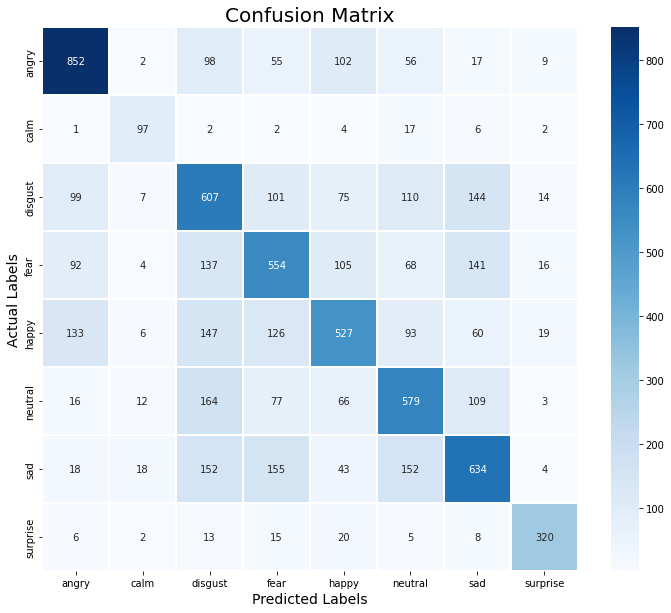

              precision    recall  f1-score   support

         0.0       0.70      0.72      0.71      1191
         1.0       0.66      0.74      0.70       131
         2.0       0.46      0.52      0.49      1157
         3.0       0.51      0.50      0.50      1117
         4.0       0.56      0.47      0.51      1111
         5.0       0.54      0.56      0.55      1026
         6.0       0.57      0.54      0.55      1176
         7.0       0.83      0.82      0.82       389

    accuracy                           0.57      7298
   macro avg       0.60      0.61      0.60      7298
weighted avg       0.57      0.57      0.57      7298



In [ ]:
cm = confusion_matrix(y_test3, y_pred3)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test3, y_pred3))

Tải các mô hình về

In [ ]:
from google.colab import files
files.download('/content/Knn.pkl')
files.download('/content/CNN.pkl')
files.download('/content/SVM.pkl')
files.download('/content/LogisticRegresion.pkl')